<img src="https://www.analyticsvidhya.com/wp-content/themes/Curated/custom-design/images/logo.png" width=240 height= 240 align="right"/>

# Text Classification Project 
## Travail Pratique - TP1 Machine learning Apprentissage Supervisé
### Étudiant: Carlos Cavalcante
### Prof: Hafed Benteftifa
“Text Classification” is one of the most important NLP tasks. It is the process of classifying text strings or documents into different categories, based upon the contents of the strings. Some examples of text classification are:

* Understanding audience sentiment from social media,
* Detection of spam and non-spam emails,
* Auto tagging of customer queries, and
* Classifying blog posts into different categories.

In this notebook, we will work on a text classification problem, end-to-end. For this analysis, we’ll be using the __http://mlg.ucd.ie/datasets/bbc.html  (BBCSport Fulltext)__ compiled by BBC Broadcast.

*Note: Python version = 3.6*

### Table of Contents

1. Understand the Problem Statement
2. Read Dataset
3. Clean and Pre-Process Text
4. Split Data
4. Extracting Features from Cleaned Text
5. Model Building

<br>

### Understand the Problem Statement


The bbcsports is a collection of 5 very popular and known sports in Britain: Football (as Soccer), Cricket, Tennis, Athletics and Rugby.

In this project, our task is to develop a model able to classify a new article (Generalize) into one of these topics citing above. 

### Read Dataset

Let's import the necessary libraries.

In [25]:
import numpy as np
import pandas as pd
import nltk
import spacy
from tqdm import tqdm
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

There are five folders named: "atlhetics", "cricket", "football", "tennis" and "rugby" containing text. We will have to first read and load the contents of these text files to move ahead with our analysis.

In [26]:
# load file names
athletics_files = os.listdir("athletics/")
cricket_files = os.listdir("cricket/")
football_files = os.listdir("football/")
rugby_files = os.listdir("rugby/")
tennis_files = os.listdir("tennis/")

In [27]:
print(athletics_files[:10])
print('--'*45)
print(cricket_files[:10])
print('--'*45)
print(football_files[:10])
print('--'*45)
print(rugby_files[:10])
print('--'*45)
print(tennis_files[:10])

['060.txt', '074.txt', '048.txt', '100.txt', '101.txt', '049.txt', '075.txt', '061.txt', '088.txt', '077.txt']
------------------------------------------------------------------------------------------
['060.txt', '074.txt', '048.txt', '114.txt', '100.txt', '101.txt', '115.txt', '049.txt', '075.txt', '061.txt']
------------------------------------------------------------------------------------------
['262.txt', '060.txt', '074.txt', '048.txt', '114.txt', '100.txt', '128.txt', '129.txt', '101.txt', '115.txt']
------------------------------------------------------------------------------------------
['060.txt', '074.txt', '048.txt', '114.txt', '100.txt', '128.txt', '129.txt', '101.txt', '115.txt', '049.txt']
------------------------------------------------------------------------------------------
['060.txt', '074.txt', '048.txt', '100.txt', '049.txt', '075.txt', '061.txt', '088.txt', '077.txt', '063.txt']


...................................................................................................................

Let's see how many info for athletics, cricket, football, rugby and tennis are there.

In [28]:
len(athletics_files), len(cricket_files), len(football_files), len(rugby_files), len(tennis_files)

(102, 124, 265, 147, 100)

Till now we have just gathered the names of files that we have to read. To read them, let's define a function.

In [29]:
# function to read text files
def read_classify(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='cp1252')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [30]:
# read and store athletics words in a list
athletics = []

for i in athletics_files:
    athletics.append(read_classify("athletics/"+i))
    
# read and store cricket words in a list
cricket = []

for i in cricket_files:
    cricket.append(read_classify("cricket/"+i))
    
# read and store football words in a list
football = []

for i in football_files:
    football.append(read_classify("football/"+i))
    
# read and store rugby words in a list
rugby = []

for i in rugby_files:
    rugby.append(read_classify("rugby/"+i))
    
# read and store tennis words in a list
tennis = []

for i in tennis_files:
    tennis.append(read_classify("tennis/"+i))

We will now put all of them in a dataframe and will also assign from 0 to 4 their classification.

In [31]:
len(athletics_files), len(cricket_files), len(football_files), len(rugby_files), len(tennis_files)

(102, 124, 265, 147, 100)

In [32]:
import sys
df = pd.DataFrame({'classify':(athletics+cricket+football+rugby+tennis)})

df['class'] = 0 # 0 for Athletics
df['class'][101:225] = 1 # 1 for cricket
df['class'][225:490] = 2 # 2 for football
df['class'][490:637] = 3 # 3 for rugby
df['class'][637:] = 4 # 4 for tennis

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [33]:
# check class distribution
df['class'].value_counts()

2    265
3    147
1    124
4    101
0    101
Name: class, dtype: int64

<br>

### Clean and Pre-Process Text

Cleaning and pre-processing of raw text data is an important step in an NLP task. We try to remove as much noise as possible from the data. Punctuation marks, special characters(#@&<!), and words like 'the', 'a', 'of', 'oh' are of not much use in tasks like text classification, and that is why they are considered as noise. So, before getting started, let's print out a random classify.  

In [34]:
df['classify'][4]

'Event devised to nurture athletes\n\nUK Athletics has launched a new outdoor series aimed at creating extra competitive events for athletes just below Great Britain standard.\n\nThe UK Challenge will consist of 10 high standard meetings from May until the series final on 3 September. Athletes must compete in at least three events to gain a series ranking with the top eight athletes in each discipline contesting the final. The scheme also coincides with plans to introduce a new UK ranking system. A list of the top 100 athletes in each event will be compiled and updated every two weeks throughout the outdoor season. UK Athletics chief executive David Moorcroft said he hoped the initiatives would stimulate the sport at all levels. "We are building on the development of domestic competition started in the indoor season and will be looking to affect the careers of thousands of British athletes," said Moorcroft. "This is an athlete driven programme and identifies a strata of competitors who

...................................................................................................................

As you can see, we have lots of punctuation marks and html tags. To get rid of them from the text we will take help of regular expressions. 

In [35]:
replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# function to clean text data
def clean_classifies(classifies):
    classifies = [replace_1.sub("", line.lower()) for line in classifies]
    classifies = [replace_2.sub(" ", line) for line in classifies]
    return classifies

In [36]:
df['classify'] = clean_classifies(df['classify'])

Let's pull out the same classify after the cleaning operation.

In [37]:
df['classify'][4]

'event devised to nurture athletes\n\nuk athletics has launched a new outdoor series aimed at creating extra competitive events for athletes just below great britain standard\n\nthe uk challenge will consist of 10 high standard meetings from may until the series final on 3 september athletes must compete in at least three events to gain a series ranking with the top eight athletes in each discipline contesting the final the scheme also coincides with plans to introduce a new uk ranking system a list of the top 100 athletes in each event will be compiled and updated every two weeks throughout the outdoor season uk athletics chief executive david moorcroft said he hoped the initiatives would stimulate the sport at all levels we are building on the development of domestic competition started in the indoor season and will be looking to affect the careers of thousands of british athletes said moorcroft this is an athlete driven programme and identifies a strata of competitors who will provi

...................................................................................................................

It seems pretty neat and free from unwanted elements. Now let's see which are the top most frequent words in the data.

In [38]:
from nltk import FreqDist

In [39]:
# function to plot top n most frequent words
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

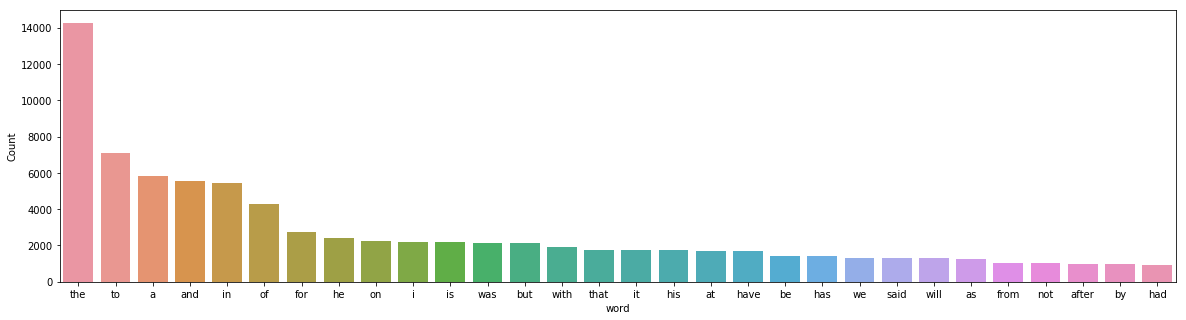

In [40]:
freq_words(df['classify'])

As it turns out, terms like 'and', 'a', 'is', that' etc. are the most common terms in our data. Most of them are also known as stopwords in the NLP community, and they would be of little help in identifying a classify as athtletics, football...etc. Hence, we will get rid of them as well. 

We will use __spaCy library__ here to remove the stopwords. But first I am going to download spaCy's language model 'en_core_web_sm'. Use the command below in your terminal to download and install the language model.

```python -m spacy download en_core_web_sm```

In [41]:
nlp = spacy.load('en_core_web_sm')

However, - sometimes -  there are a few stopwords which should not be removed as their absence might change the meaning of an entire sentence. So, for exemple, we won't remove the words 'however', 'no', 'not', and 'but'. We will take them off from spaCy's stopwords vocabulary in the following code block.

In [55]:
# nlp.vocab['however'].is_stop = False
# nlp.vocab['no'].is_stop = False
# nlp.vocab['not'].is_stop = False
# nlp.vocab['but'].is_stop = False

__Tokenization__

To remove the stopwords, we will have to first tokenize our classifies. Tokenization means splitting a piece of text into its constituent words. For example, the sentence below will be split into a list of tokens/words after tokenization.

__"The cutting edge of the plot is compromised" --> ['The', 'cutting', 'edge', 'of', 'the', 'plot', 'is', 'compromised']__

We will again use spaCy for tokenizaion. First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

* Does the substring match a tokenizer exception rule? For example, "don't" does not contain whitespace, but should be split into two tokens, "do" and "n't", while "U.K." should always remain one token.
 
* Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there's a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

<img src="https://spacy.io/assets/img/tokenization.svg" align="center"/>


In [56]:
# tokenization using spaCy
def tokenization(x):
    classifies_tokens = []
    for i in tqdm(x):
        i = nlp(i)
        temp = []
        for j in i:
            temp.append(j.text)
        classifies_tokens.append(temp)
    
    return classifies_tokens

In [50]:
df['tokenized_classify'] = tokenization(df['classify'])

100%|██████████| 738/738 [01:09<00:00, 10.65it/s]


In [59]:
# function to remove stopwords
def strip_stopwords(classifies):
    s = []
    for r in tqdm(classifies):
        s_2 = []
        for token in r:
            if nlp.vocab[token].is_stop == True:
                continue
            else:
                s_2.append(token)
        s.append(" ".join(s_2))    
        
    return s

Let's remove the stopwords.

In [60]:
df['classify_cleaned'] = strip_stopwords(df['tokenized_classify'])

100%|██████████| 738/738 [00:00<00:00, 1748.04it/s]


We will again check the most common terms in the cleaned classify text after eliminating the stopwords.

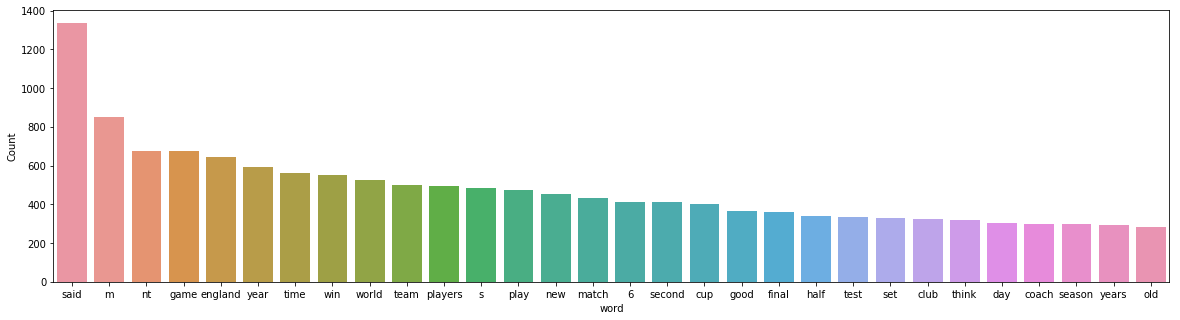

In [61]:
freq_words(df['classify_cleaned'])

Now we can see more relevant terms have come up. Words such as 'game', 'team', 'play', 'character' as most frequently appearing words make sense. However, we can further clean up the data. Let's get rid of single character terms. 

In [62]:
# remove 1 character terms (length == 1)
df['classify_cleaned'] = df['classify_cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

One more glance at the top 30 most common words.

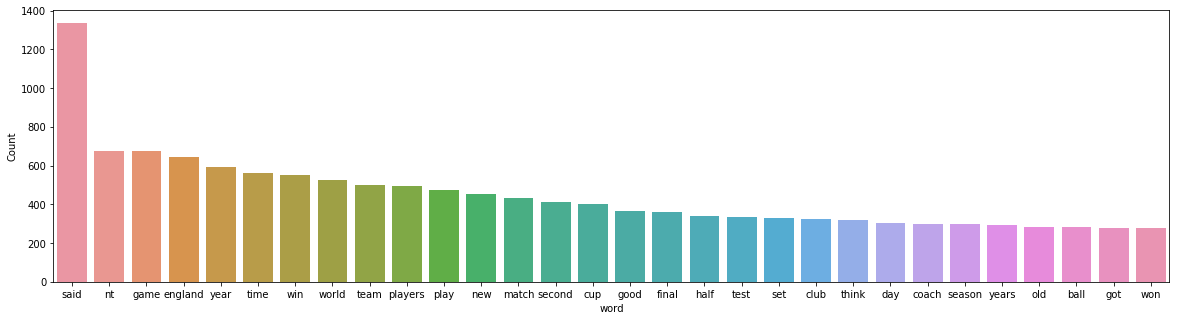

In [63]:
freq_words(df['classify_cleaned'])

<br>

### Split Data

After cleaning and pre-processing of the classifies, we can now split our data into 3 sets — train, validation, and test — in the ratio of 70%, 15% and 15%, respectively. We will use the train set for traing our model, and validation and test sets to make predictions and evaluate our model.

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
# splitting data into train, test, and validation set
train, temp = train_test_split(df, stratify = df['class'], test_size=0.3, random_state=42)

test, val = train_test_split(temp, stratify = temp['class'], test_size=0.5, random_state=42)

In [66]:
train.shape, val.shape, test.shape

((516, 4), (111, 4), (111, 4))

<br>

### Extracting Features from Cleaned Text

Since we will building a classification model, we can't directly feed text data to our model. We will have to extract numerical features from the cleaned text to build our model. We will create two sets of features:
1. Bag-of-Words features
2. TF-IDF features

In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [68]:
# build bag-of-words features for train data
bow = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))
bow_train = bow.fit_transform(train['classify_cleaned'])

# build TF-IDF features for train data
tfidf = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                        sublinear_tf=True)
tfidf_train = tfidf.fit_transform(train['classify_cleaned'])

In [69]:
# create features for validation and test set
bow_val = bow.transform(val['classify_cleaned'])
tfidf_val = tfidf.transform(val['classify_cleaned'])

bow_test = bow.transform(test['classify_cleaned'])
tfidf_test = tfidf.transform(test['classify_cleaned'])

In [70]:
print('BOW model:> Train features shape:', bow_train.shape, ' Validation features shape:', bow_val.shape, 
      ' Test features shape:', bow_test.shape)

print('TFIDF model:> Train features shape:', tfidf_train.shape, ' Validation features shape:', tfidf_val.shape,
      ' Test features shape:', tfidf_test.shape)

BOW model:> Train features shape: (516, 3694)  Validation features shape: (111, 3694)  Test features shape: (111, 3694)
TFIDF model:> Train features shape: (516, 3694)  Validation features shape: (111, 3694)  Test features shape: (111, 3694)


<br>

### Model Building

1) __Logistic Regression__ Model using bag-of-words features

In [71]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression

In [72]:
lr = LogisticRegression()

# train model on bag-of-words features
lr.fit(bow_train, train['class'])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
#make predictions on validation set
bow_val_preds = lr.predict(bow_val)

#make predictions on test set
bow_test_preds = lr.predict(bow_test)

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
# model evaluaton
print("Validation accuracy score: ", accuracy_score(val['class'], bow_val_preds))
print("Test accuracy score: ", accuracy_score(test['class'], bow_test_preds))

Validation accuracy score:  0.990990990990991
Test accuracy score:  0.9819819819819819


2) __Logistic Regression__ Model using TF-IDF features

In [76]:
# train model on bag-of-words features
lr.fit(tfidf_train, train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [77]:
#make predictions on validation set
tfidf_val_preds = lr.predict(tfidf_val)

#make predictions on test set
tfidf_test_preds = lr.predict(tfidf_test)

In [78]:
# model evaluaton
print("Validation accuracy score: ", accuracy_score(val['class'], tfidf_val_preds))
print("Test accuracy score: ", accuracy_score(test['class'], tfidf_test_preds))

Validation accuracy score:  0.954954954954955
Test accuracy score:  0.963963963963964


<br>

### Livrable
1. Identifier l’approche à utiliser. Est-ce que l’on est dans un cas de classification? Expliquer.
2. Exploration des données :
3. Déterminer les statistiques que vous pensez être intéressantes pour ce projet.
4. Préparation des données :
5. Identifier les features/prédicteurs et la colonne cible
6. Effectuer un ou des prétraitements sur les colonnes feature
7. Partager les données en training et test
8. Modèle d’apprentissage et test évaluation
9. Choisir les modèles d’apprentissage supervisé qui sont appropriés pour ce problème. On pourra utiliser scikit-learn pour l’implémentation.
10. Indiquer la nature du modèle proposé en termes des avantages et des inconvénients
11. Quelles sont les critères qui ont fait que vous avez choisi cette approche? Est-ce que c’est basé sur la nature des données que vous avez reçu?
12. Pour chaque modèle, donner une table qui montre le temps nécessaire pour l’apprentissage, temps pour faire la prédiction, le score F1 sur le set training, le score F1 sur le test set.
13. Choix du meilleur modèle : indiquer lequel serait le meilleur modèle pour les données que vous avez reçu. Indiquer vos critères tel que : données disponibles, ressources de calcul, cout, performance


### Challenges :

Le premier problème à résoudre est de trouver les X features à utiliser pour la prédiction des classes. Dans notre cas, on recoit des fichiers au lieu d’enregistrements.
Quelques approches à évaluer pour transformer le texte dans un document en un espace de features : 

1. Word Count Vectors
2. TF–IDF Vectors
3. Word Embeddings
4. Text based or NLP based features
5. Latent Dirichlet Allocation
6. BERT


#### Important : 

Aucune approche d’apprentissage ne sera considérée pour ce projet.

### Plus:
1. Score F1 
2. Use text normalization (stemming or lemmatization) to convert different forms of each word into one.
3. Use word embeddings such as word2vec, GLoVe, fasttext to create features.
4. Try different machine learning algorithms like SVM, random forest, XGBoost, LightGBM.
5. Ressource de calcul